In [1]:
import sys
import subprocess
import pkg_resources

required = {'numpy', 'pandas', 'tensorflow', 'keras'}
installed = {pkg.key for pkg in pkg_resources.working_set}
missing = required - installed

if missing:
    python = sys.executable
    subprocess.check_call([python, '-m', 'pip', 'install', *missing], stdout=subprocess.DEVNULL)

In [2]:
import tensorflow as tf
import numpy as np
import pandas as pd

### Import images

In [3]:
import os
import random

if not os.path.exists('keras_classification_sample'):
  !git clone https://github.com/pazamelin/keras_classification_sample.git

IMG_DIR = f'./keras_classification_sample/concrete-cracks/'
CONFIG = {
    'image_size': (227, 227),
    'batch_size': 16,
    'validation_split': 0.2,
    'seed': random.randint(0, 99999) 
}

train_ds = tf.keras.utils.image_dataset_from_directory(IMG_DIR, **CONFIG, subset="training")
validation_ds = tf.keras.utils.image_dataset_from_directory(IMG_DIR, **CONFIG, subset="validation")

class_names = train_ds.class_names
print(f'Class_names: {class_names}')

AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
validation_ds = validation_ds.cache().prefetch(buffer_size=AUTOTUNE)

Cloning into 'keras_classification_sample'...
remote: Enumerating objects: 38442, done.
remote: Counting objects: 100% (38442/38442), done.
remote: Compressing objects: 100% (38427/38427), done.
remote: Total 38442 (delta 14), reused 38442 (delta 14), pack-reused 0
Receiving objects: 100% (38442/38442), 221.99 MiB | 28.46 MiB/s, done.
Resolving deltas: 100% (14/14), done.
Checking out files: 100% (12005/12005), done.
Found 10000 files belonging to 2 classes.
Using 8000 files for training.
Found 10000 files belonging to 2 classes.
Using 2000 files for validation.
Class_names: ['negative', 'positive']


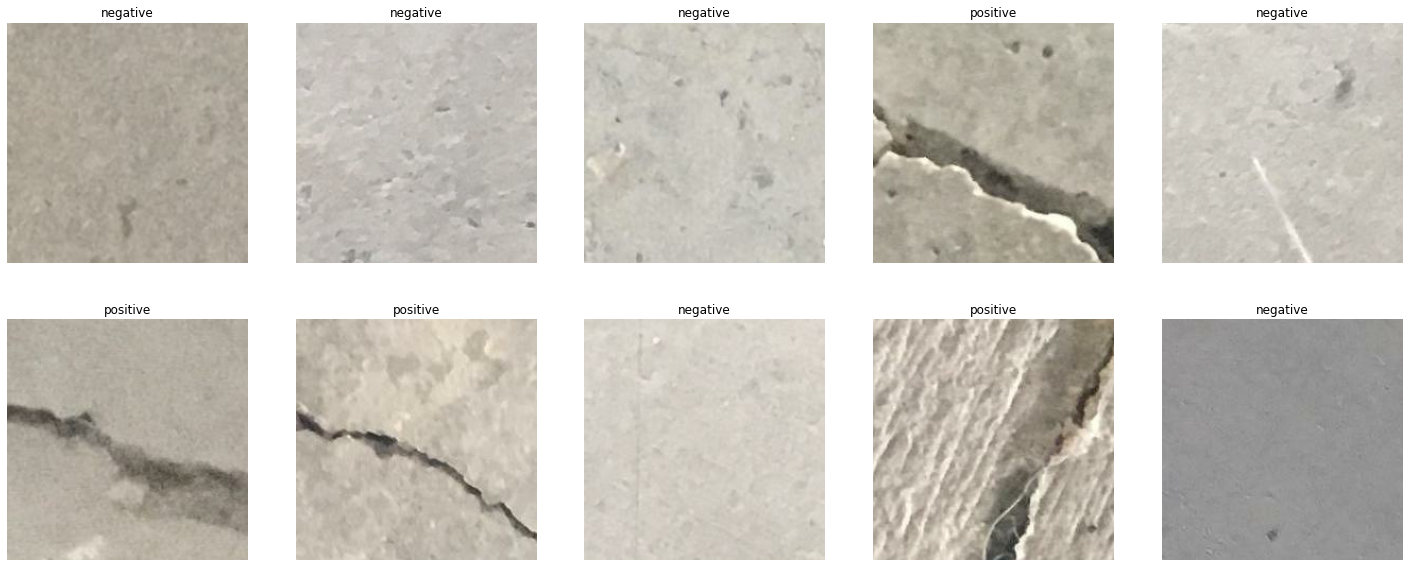

In [4]:
import matplotlib.pyplot as plt

plt.figure(figsize=(25, 10))
for images, labels in train_ds.take(1):
  for i in range(10):
    ax = plt.subplot(2, 5, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

## Custom CNN

### Instantiate a model

We've tried to keep the network as small as possible, but the input images are rather big, so we need several Conv2D + MaxPooling2D stages.
Overall it's a simple CNN with regularization and several dropout layers to reduce overfitting. 

In [5]:
from tensorflow.keras import models, layers, regularizers

model = models.Sequential()
# Conv2D + MaxPooling stages
model.add(layers.Conv2D(32, (6, 6), activation='relu',input_shape=(227, 227, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (6, 6), activation='relu', kernel_regularizer=regularizers.l2(0.002)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(256, (6, 6), activation='relu', kernel_regularizer=regularizers.l2(0.002)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.5))
model.add(layers.Conv2D(256, (6, 6), activation='relu', kernel_regularizer=regularizers.l2(0.002)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
# a single unit with a sigmoid activation to end up with binary classification probabilities
model.add(layers.Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 222, 222, 32)      3488      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 111, 111, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 106, 106, 128)     147584    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 53, 53, 128)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 48, 48, 256)       1179904   
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 24, 24, 256)       0         
_________________________________________________________________
dropout (Dropout)            (None, 24, 24, 256)       0

### Configure the model for training

In [6]:
from tensorflow.keras import optimizers

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(learning_rate=1e-5),
              metrics=['acc']
)

### Fit the model

In [7]:
import time

# timing callback
class TimeHistory(tf.keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.times = []

    def on_epoch_begin(self, batch, logs={}):
        self.epoch_time_start = time.time()

    def on_epoch_end(self, batch, logs={}):
        self.times.append(time.time() - self.epoch_time_start)
        
time_callback = TimeHistory()

# fit model
history = model.fit(train_ds,
                    steps_per_epoch=25,
                    epochs=20,
                    validation_data=validation_ds,
                    validation_steps=50,
                    callbacks=[time_callback]
)

Epoch 1/20
25/25 [==============================] - 42s 331ms/step - loss: 8.3389 - acc: 0.5425 - val_loss: 2.3504 - val_acc: 0.4800
Epoch 2/20
25/25 [==============================] - 8s 327ms/step - loss: 3.3216 - acc: 0.6050 - val_loss: 1.2812 - val_acc: 0.8575
Epoch 3/20
25/25 [==============================] - 8s 330ms/step - loss: 2.4466 - acc: 0.6775 - val_loss: 3.2062 - val_acc: 0.5225
Epoch 4/20
25/25 [==============================] - 8s 327ms/step - loss: 1.8030 - acc: 0.7800 - val_loss: 1.1245 - val_acc: 0.9200
Epoch 5/20
25/25 [==============================] - 8s 329ms/step - loss: 1.5747 - acc: 0.8075 - val_loss: 1.0790 - val_acc: 0.9550
Epoch 6/20
25/25 [==============================] - 8s 328ms/step - loss: 1.2731 - acc: 0.8825 - val_loss: 1.1427 - val_acc: 0.9050
Epoch 7/20
25/25 [==============================] - 8s 329ms/step - loss: 1.0745 - acc: 0.9325 - val_loss: 1.6893 - val_acc: 0.7588
Epoch 8/20
25/25 [==============================] - 8s 328ms/step - loss: 1

In [8]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go

fig = make_subplots(rows=1, cols=2,
                    subplot_titles = ['Training and Validation Accuracy',
                                      'Training and Validation Loss'])

plots_positions = [(1, 1)] * 2 + [(1, 2)] * 2
metric_names = ['acc', 'val_acc', 'loss', 'val_loss']
epochs = list(range(1, history.params['epochs'] + 1))

for metric, (plot_row, plot_col) in zip(metric_names, plots_positions):
  fig.add_trace(
    go.Scatter(name=metric,
               x=epochs,
               y=history.history[metric]),
  row=plot_row, 
  col=plot_col
)   

fig.show()


### Model evaluation

In [17]:
FV_IMG_DIR = f'./keras_classification_sample/final-validation'

evaluate_ds = tf.keras.utils.image_dataset_from_directory(FV_IMG_DIR, image_size=(227,227), batch_size=25)
print("Evaluate on test data")
custom_cnn_fv = model.evaluate(evaluate_ds, batch_size=25)
print("test loss, test acc:", custom_cnn_fv)

Found 2000 files belonging to 2 classes.
Evaluate on test data
80/80 [==============================] - 10s 75ms/step - loss: 0.9136 - acc: 0.9530
test loss, test acc: [0.9136314988136292, 0.953000009059906]


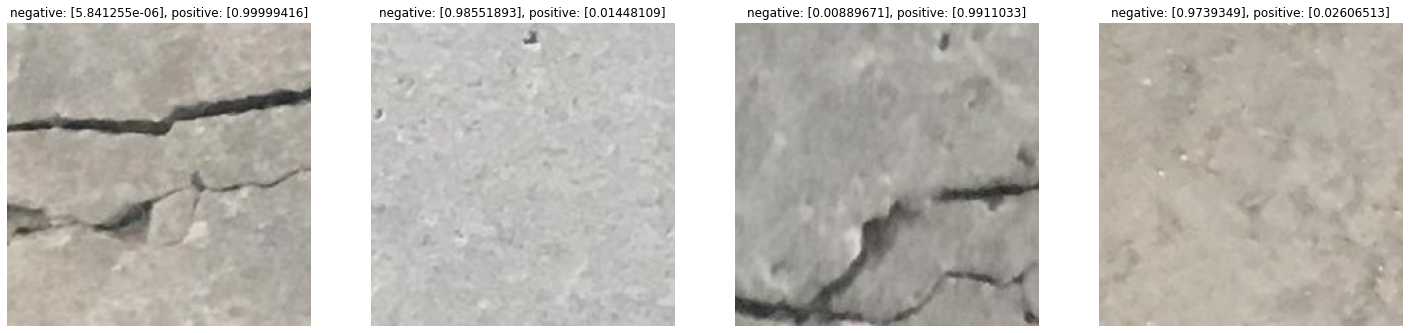

In [18]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import plotly.express as px
import os, random
import matplotlib.pyplot as plt

columns = 4
fig = make_subplots(rows=1, cols=columns)

img_names = []
for i in range(0, int(columns / 2)):
  img_names.append(f'{FV_IMG_DIR}/positive/' + random.choice(os.listdir(f'{FV_IMG_DIR}/positive/')))
  img_names.append(f'{FV_IMG_DIR}/negative/' + random.choice(os.listdir(f'{FV_IMG_DIR}/negative/')))


plt.figure(figsize=(25, 10))
for i, img_name in enumerate(img_names):
  ax = plt.subplot(1, columns, i + 1)
  img = tf.keras.preprocessing.image.load_img(img_name, target_size=(227, 227))
  img_array = tf.keras.preprocessing.image.img_to_array(img)
  plt.imshow(img_array/255.)
  img_array = tf.expand_dims(img_array, 0)  # Create batch axis
  score = model.predict(img_array)[0]
  plt.title(f'negative: {1 - score}, positive: {score}')
  plt.axis("off")


## Framework Network

В качестве готовой архитектуры мы выбрали Xception по причине относительно небольшого размера и высокой точности.

In [9]:
from tensorflow.keras.applications import Xception
from tensorflow.keras.preprocessing import image

base_model = Xception(include_top=False, 
                  weights='imagenet', 
                  input_shape=((227, 227, 3)))


83697664/83683744 [==============================] - 1s 0us/step


In [10]:
from tensorflow.keras.layers import GlobalAveragePooling2D, MaxPooling2D

x = base_model.output
x = layers.Conv2D(32, (3, 3), activation='relu')(x)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Flatten()(x)
x = layers.Dense(128, activation='relu')(x)

top_model = layers.Dense(1, activation='sigmoid')(x)

model_x = models.Model(inputs=base_model.input, outputs=top_model)


In [11]:
model_x.compile(optimizer=optimizers.RMSprop(learning_rate=1e-5), 
                loss='binary_crossentropy',
                metrics=["accuracy"])

# model_x.summary()


In [14]:
time_callback_x = TimeHistory()

history_x = model_x.fit(train_ds,
             steps_per_epoch=25,
             epochs=10,
             validation_data=validation_ds,
             callbacks=[time_callback_x]
)

Epoch 1/10
25/25 [==============================] - 36s 1s/step - loss: 0.0419 - accuracy: 0.9900 - val_loss: 0.0810 - val_accuracy: 0.9745
Epoch 2/10
25/25 [==============================] - 36s 1s/step - loss: 0.0155 - accuracy: 0.9975 - val_loss: 0.0376 - val_accuracy: 0.9905
Epoch 3/10
25/25 [==============================] - 36s 1s/step - loss: 0.0134 - accuracy: 1.0000 - val_loss: 0.0311 - val_accuracy: 0.9905
Epoch 4/10
25/25 [==============================] - 36s 1s/step - loss: 0.0090 - accuracy: 0.9975 - val_loss: 0.0269 - val_accuracy: 0.9905
Epoch 5/10
25/25 [==============================] - 36s 1s/step - loss: 0.0030 - accuracy: 1.0000 - val_loss: 0.0199 - val_accuracy: 0.9925
Epoch 6/10
25/25 [==============================] - 36s 1s/step - loss: 0.0021 - accuracy: 1.0000 - val_loss: 0.0153 - val_accuracy: 0.9945
Epoch 7/10
25/25 [==============================] - 36s 1s/step - loss: 0.0820 - accuracy: 0.9800 - val_loss: 0.0121 - val_accuracy: 0.9955
Epoch 8/10
25/25 [==

In [15]:
fig = make_subplots(rows=1, cols=2,
                    subplot_titles = ['Training and Validation Accuracy',
                                      'Training and Validation Loss'])

plots_positions = [(1, 1)] * 2 + [(1, 2)] * 2
metric_names = ['accuracy', 'val_accuracy', 'loss', 'val_loss']
epochs = list(range(1, history_x.params['epochs'] + 1))

for metric, (plot_row, plot_col) in zip(metric_names, plots_positions):
  fig.add_trace(
    go.Scatter(name=metric,
               x=epochs,
               y=history_x.history[metric]),
  row=plot_row, 
  col=plot_col
)   

fig.show()

In [19]:
evaluate_ds = tf.keras.utils.image_dataset_from_directory(FV_IMG_DIR, image_size=(227,227), batch_size=25)
print("Evaluate on test data")
framework_cnn_fv = model_x.evaluate(evaluate_ds, batch_size=25)
print("test loss, test acc:", framework_cnn_fv)

Found 2000 files belonging to 2 classes.
Evaluate on test data
80/80 [==============================] - 21s 247ms/step - loss: 0.0086 - accuracy: 0.9970
test loss, test acc: [0.008647061884403229, 0.996999979019165]


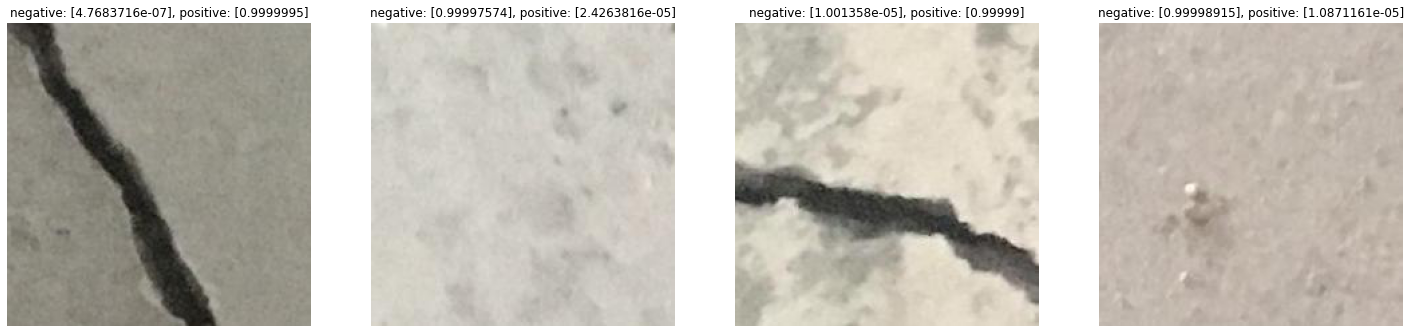

In [20]:
columns = 4
fig = make_subplots(rows=1, cols=columns)

img_names = []
for i in range(0, int(columns / 2)):
  img_names.append(f'{FV_IMG_DIR}/positive/' + random.choice(os.listdir(f'{FV_IMG_DIR}/positive/')))
  img_names.append(f'{FV_IMG_DIR}/negative/' + random.choice(os.listdir(f'{FV_IMG_DIR}/negative/')))


plt.figure(figsize=(25, 10))
for i, img_name in enumerate(img_names):
  ax = plt.subplot(1, columns, i + 1)
  img = tf.keras.preprocessing.image.load_img(img_name, target_size=(227, 227))
  img_array = tf.keras.preprocessing.image.img_to_array(img)
  plt.imshow(img_array/255.)
  img_array = tf.expand_dims(img_array, 0)  # Create batch axis
  score = model_x.predict(img_array)[0]
  plt.title(f'negative: {1 - score}, positive: {score}')
  plt.axis("off")


## Training Times Comparison

In [21]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go

fig = make_subplots(rows=1, cols=2,
                    subplot_titles = ['training time per epoch',
                                      'total time'])
timing_data = [time_callback.times, time_callback_x.times]
timing_names = ['custom CNN', 'framework CNN']
epochs = list(range(1, history.params['epochs'] + 1))

for data, name in zip(timing_data, timing_names):
  # plot time per epoch
  fig.add_trace(
    go.Scatter(name=name,
               x=epochs,
               y=data),
    row = 1, col = 1   
  ) 

# plot total time
total_times = [sum(data) for data in timing_data]
fig.add_trace(
  go.Bar(name='total time',
         x=timing_names,
         y=total_times),
    row = 1, col = 2   
  )

fig.show()


## Final validation comparison

In [22]:
print("custom CNN: test loss , test acc:", custom_cnn_fv)
print("framework CNN: test loss, test acc:", framework_cnn_fv)

custom CNN: test loss , test acc: [0.9136314988136292, 0.953000009059906]
framework CNN: test loss, test acc: [0.008647061884403229, 0.996999979019165]


Параметры для моделей подбирались для максимальной точности. Из наблюдений можно выделить переобучение, которое было замечено при проверке первой модели. От него получилось избавиться подобрав подходящую структуру сети и параметры.